In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
taxon = 9606

In [3]:
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)


In [4]:
ref_literature = datasets.reference_publications(taxon)

In [5]:
agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

In [6]:
%%time
ml = ncbi.pubmed('main', ['pubmed_id', 'year'])

CPU times: total: 1.64 s
Wall time: 1.86 s


In [7]:
%%time
gene2pubmed = gene2lit #ncbi.gene2pubmed(taxon_ncbi=9606)
gene2pubmed = pd.merge(gene2pubmed, ml, how='left')
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

CPU times: total: 4.97 s
Wall time: 4.97 s


In [8]:
gene2pubmed_gene_count = gene2pubmed.groupby('pubmed_id').count()['gene_ncbi']

gene2pubmed_slice = gene2pubmed[gene2pubmed['pubmed_id'].isin(gene2pubmed_gene_count[gene2pubmed_gene_count == 1].index)]

In [9]:
np.mean(gene2pubmed_gene_count != 1)

0.3049324923515905

In [10]:
%%time
icite_stats = nih.icite(dataset='studies', columns=['pubmed_id', 'citation_count'])

CPU times: total: 1.12 s
Wall time: 1.29 s


In [11]:
%%time
gene2pubmed_slice = pd.merge(gene2pubmed_slice, icite_stats[icite_stats.columns[icite_stats.columns != 'year']],
                             how='left', on='pubmed_id')

CPU times: total: 5.86 s
Wall time: 5.84 s


In [28]:
%%time
np.random.seed(10)
year_array = range(1970, 2020)
corr_array = []
p_array = []
bootstrap_array = []
cite_median_df_array = []
for year in year_array:
    pub_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').count()['pubmed_id']
    cite_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').sum()['citation_count']
    cite_median = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').median()['citation_count']
    cite_mean = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').mean()['citation_count']

    gene2pubmed_dict = gene2pubmed[(~gene2pubmed['pubmed_id'].isin(large_pubs)) & 
            (gene2pubmed['year'] < year)].value_counts('gene_ncbi').to_dict()
    
    def gene2pubmed_gene_count(x):
        ret = gene2pubmed_dict.get(x)
        if ret:
            return ret
        else:
            return 0

    pub_count_previous = np.array([gene2pubmed_gene_count(x) for x in cite_count.index])
    rho, p = scipy.stats.spearmanr(pub_count_previous, cite_median)
    corr_array.append(rho)
    p_array.append(p)
    
    # bootstrapping estimates
    cite_median_df = pd.DataFrame(cite_median)
    cite_median_df['pub_count_previous'] = pub_count_previous
    cite_median_df['year'] = year
    cite_median_df_array.append(cite_median_df)
    
    bootstrap = []
    for n_b in range(1000):
        rho, p = scipy.stats.spearmanr(cite_median_df.sample(frac=1, replace=True))
        bootstrap.append(rho)
        
    bootstrap_array.append(bootstrap)

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\stats\_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\stats\_stats_py.p

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c

CPU times: total: 37.6 s
Wall time: 37.5 s


In [32]:
pd.concat(cite_median_df_array).to_csv('../data/citation_count_vs_previous_pubs.csv')

In [13]:
tick_array = []
for mult in [1, 10, 100, 1000]:
    tick_array = tick_array + list(mult*np.array([1,2,3,4,5,6,7,8,9]))
tick_array = np.log10(np.array(tick_array))

In [14]:
tick_array

array([0.        , 0.30103   , 0.47712125, 0.60205999, 0.69897   ,
       0.77815125, 0.84509804, 0.90308999, 0.95424251, 1.        ,
       1.30103   , 1.47712125, 1.60205999, 1.69897   , 1.77815125,
       1.84509804, 1.90308999, 1.95424251, 2.        , 2.30103   ,
       2.47712125, 2.60205999, 2.69897   , 2.77815125, 2.84509804,
       2.90308999, 2.95424251, 3.        , 3.30103   , 3.47712125,
       3.60205999, 3.69897   , 3.77815125, 3.84509804, 3.90308999,
       3.95424251])

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\richa\AppData\Local\Temp\ipykernel_15416\1372798044.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['',r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
C:\Users\richa\AppData\Local\Temp\ipykernel_15416\1372798044.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['',r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])


Text(0.52, 0.9, 'b')

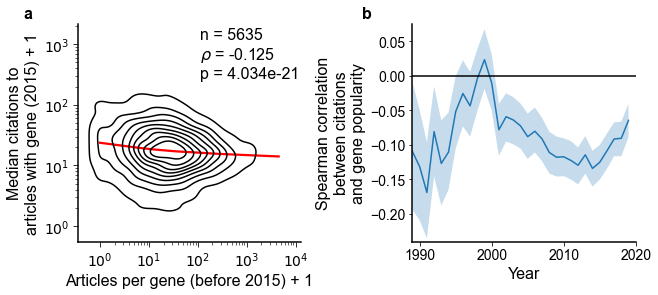

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), gridspec_kw={'wspace':0.5})

# panel a
ax = axes[0]
year = 2015
pub_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').count()['pubmed_id']
cite_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').sum()['citation_count']
cite_median = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').median()['citation_count']\

gene2pubmed_dict = gene2pubmed[(~gene2pubmed['pubmed_id'].isin(large_pubs)) & 
            (gene2pubmed['year'] < year)].value_counts('gene_ncbi').to_dict()
def gene2pubmed_gene_count(x):
    ret = gene2pubmed_dict.get(x)
    if ret:
        return ret
    else:
        return 0
        
pub_count_previous = np.array([gene2pubmed_gene_count(x) for x in cite_count.index])

sns.regplot(x=np.log10(pub_count_previous+1), y=np.log10(cite_median+1), lowess=True,
            scatter_kws={"color": "k", 's': 0, 'alpha':0.25, 'linewidth':0}, 
            line_kws={"color": "red"}, ax=ax)
sns.kdeplot(np.log10(pub_count_previous+1), 
            np.log10(cite_median+1), ax=ax, color='k')
#ax.axhline(gene2pubmed_slice[gene2pubmed_slice['year'] == year]['citation_count'].median()+1)
#ax.set_xscale('log')
#ax.set_yscale('log')

ax.tick_params(labelsize=14)
ax.set_ylabel('Median citations to\narticles with gene (' + str(year) + ') + 1', fontsize=16)
ax.set_xlabel('Articles per gene (before ' + str(year) + ') + 1', fontsize=16)
[ax.spines[i].set_linewidth(1.5) for i in ax.spines]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

rho, p = scipy.stats.spearmanr(pub_count_previous, cite_median)
n_genes = len(cite_median)

ax.text(s='n = ' + str(n_genes) + '\n' + r'$\rho$ = {:.3f}'.format(rho) + '\np = ' + '{:.3e}'.format(p), 
        x=0.55, y=0.75, fontsize=16, backgroundcolor='w', bbox={'alpha':0.9, 'color':'w'}, transform=ax.transAxes)
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(tick_array))
ax.yaxis.set_minor_locator(mpl.ticker.FixedLocator(tick_array))
ax.tick_params(axis='both', length=5, which='major')
ax.tick_params(axis='both', length=3, which='minor')
ax.xaxis.set_ticklabels(['',r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
ax.yaxis.set_ticklabels(['',r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])

# panel b
ax = axes[1]
ax.plot(year_array, corr_array, linewidth=1.5)
ax.fill_between(x=year_array, 
                y1=np.percentile(bootstrap_array, 2.5, axis=1), 
                y2=np.percentile(bootstrap_array, 97.5, axis=1), alpha=0.25)
ax.axhline(0.0, linewidth=1.5, color='k')

ax.tick_params(labelsize=14)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Spearman correlation\nbetween citations\nand gene popularity', fontsize=16, rotation=90)
ax.set_xlim([1989,2020])
ax.set_yticks(np.arange(-0.5,0.5,0.05))
ax.set_ylim([-0.24,0.075])
[ax.spines[i].set_linewidth(1.5) for i in ax.spines]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.text(s='a', x=0.05, y=0.9, fontsize=16, weight='bold')
fig.text(s='b', x=0.52, y=0.9, fontsize=16, weight='bold')

In [16]:
df_array = []
for prefix in ['transcriptomics', 'aff_ms', 'crispr', 'gwas']:
    t = pd.read_csv('../data/' + prefix + '_pubmed_ids.csv')
    t['type_of_study'] = prefix
    df_array.append(t)
collected_pmids = pd.concat(df_array).reset_index(drop=True)
collected_pmids = pd.merge(collected_pmids, ml)
pmid_dict = collected_pmids.groupby('type_of_study')['pubmed_id'].apply(set).to_dict()

In [17]:
df_array = []

t = pd.read_csv('../data/gwas_hits_5e-08.csv')
t['type'] = 'gwas'
df_array.append(t)

t = pd.read_csv('../data/aff_ms_hits.csv')
t['type'] = 'aff_ms'
df_array.append(t)

t = pd.read_csv('../data/transcriptomics_hits_0.05.csv')
t['type'] = 'transcriptomics'
df_array.append(t)

t = pd.read_csv('../data/crispr_hits.csv')
t['type'] = 'crispr'
df_array.append(t)

hits_df = pd.concat(df_array).reset_index(drop=True)

In [18]:
prot_genes = hits_df[(hits_df['set'] == 'genome') & (hits_df['type'] == 'crispr')]['gene_ncbi'].values

In [19]:
ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)

MannwhitneyuResult(statistic=62851.0, pvalue=1.2631971583100559e-06)
MannwhitneyuResult(statistic=35690.0, pvalue=2.1150829206607464e-06)
MannwhitneyuResult(statistic=586326.0, pvalue=3.263587508299758e-112)
MannwhitneyuResult(statistic=1976138.5, pvalue=1.0117841058364782e-265)
MannwhitneyuResult(statistic=1172081.0, pvalue=2.6308542613978625e-79)
MannwhitneyuResult(statistic=1287701.0, pvalue=6.172858452442905e-68)
MannwhitneyuResult(statistic=212755.0, pvalue=3.466146968828419e-17)
MannwhitneyuResult(statistic=157533.5, pvalue=6.483972362711481e-23)


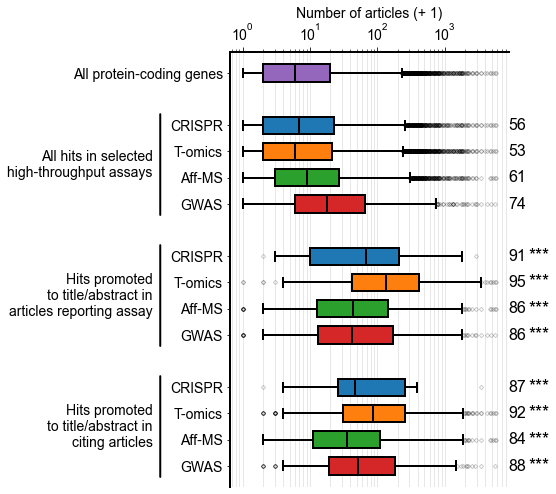

In [20]:
fig = plt.figure(figsize=(5,8))
ax = plt.gca()

pad = 0.2

medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')
flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

gene2pubmed_dict = (
        gene2pubmed
    .value_counts('gene_ncbi').to_dict()
    )

ax.boxplot(x=(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
          vert=False, 
           widths=(pad/1.5),
           positions=[-0.4], 
           whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[4], linewidth=2),
           medianprops=medianprops, 
           whiskerprops=whiskerprops, 
           capprops=capprops, 
           flierprops=flierprops)

labels = ['CRISPR', 'T-omics', 'Aff-MS', 'GWAS']

for hit_type, pad_multiplier, color in zip(['crispr', 'transcriptomics', 'aff_ms', 'gwas'], 
                                    [1,0,-1,-2], sns.color_palette()[0:4]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = hits_df_slice.groupby('set')['gene_ncbi'].apply(set).to_dict()
    
    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0) + 1)[0].values,
            #(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits_null')]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0) + 1)[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0) + 1)[0].values]

    positions = -np.arange(len(data))-1+pad_multiplier*pad
    
    ax.boxplot(x=data,
              vert=False, 
               widths=(pad/1.5),
               positions=positions,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    print(scipy.stats.mannwhitneyu(data[0], data[1]))
    print(scipy.stats.mannwhitneyu(data[0], data[2]))
    max_val = (pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].max()
    
    percentiles = ecdf([np.median(dat) for dat in data])
    
    for pos, percentile in zip(positions, percentiles):
        ax.text(s=str(int(percentile*100)), 
                x=max_val*1.5, 
                y=pos, 
                ha='left', va='center', fontsize=16)
    for pos in positions[1:]:
        ax.text(s='***', x=max_val*3, y=pos, ha='left', va='center', fontsize=18)

ax.set_xscale('log')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel('Number of articles (+ 1)', fontsize=14)
yticks = ax.get_yticks()
yticks = np.sort(yticks)[::-1]
ax.set_ylim([np.min(yticks)-pad/1.25, 
             np.max(yticks)+pad/1.25])
ax.set_yticks(ticks=yticks, 
              labels=['All protein-coding genes'] + int(len(yticks)/4)*labels,
              fontsize=14)

ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', length=5, which='major')
ax.tick_params(axis='x', length=3, which='minor')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]

# y axis labels
xpos_line = 0.06

ax.annotate('', xy=(xpos_line, -0.7), 
            xycoords='data', 
            xytext=(xpos_line, -1.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)
ax.text(s='All hits in selected\nhigh-throughput assays', 
        y=-1.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -1.7), 
            xycoords='data', 
            xytext=(xpos_line, -2.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\narticles reporting assay', 
        y=-2.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -2.7), 
            xycoords='data', 
            xytext=(xpos_line, -3.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\nciting articles', 
        y=-3.1, 
        x=xpos_line/1.3, 
        ha='right', va='center', 
        fontsize=14)

ax.grid(which='both', axis='x', linewidth=1, alpha=0.3)

#plt.savefig('../img/filter_figure.png', dpi=200, bbox_inches='tight')
#plt.savefig('../img/filter_figure.pdf', bbox_inches='tight')

#export.image('general', p='figures/filter_figure.pdf', date=True)
#export.raster_image('general', p='figures/filter_figure.png', date=True, dpi=600)

In [21]:
ecdf(1)

0.22345788078781895

In [22]:
ecdf([np.median(dat) for dat in data])

array([0.74162033, 0.86270332, 0.88432157])

In [23]:
data[0]

array([ 4., 89.,  3., ...,  3.,  4.,  8.])

MannwhitneyuResult(statistic=62851.0, pvalue=1.2631971583100559e-06)
MannwhitneyuResult(statistic=35690.0, pvalue=2.1150829206607464e-06)
MannwhitneyuResult(statistic=586326.0, pvalue=3.263587508299758e-112)
MannwhitneyuResult(statistic=1976138.5, pvalue=1.0117841058364782e-265)
MannwhitneyuResult(statistic=1172081.0, pvalue=2.6308542613978625e-79)
MannwhitneyuResult(statistic=1287701.0, pvalue=6.172858452442905e-68)
MannwhitneyuResult(statistic=212755.0, pvalue=3.466146968828419e-17)
MannwhitneyuResult(statistic=157533.5, pvalue=6.483972362711481e-23)


C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


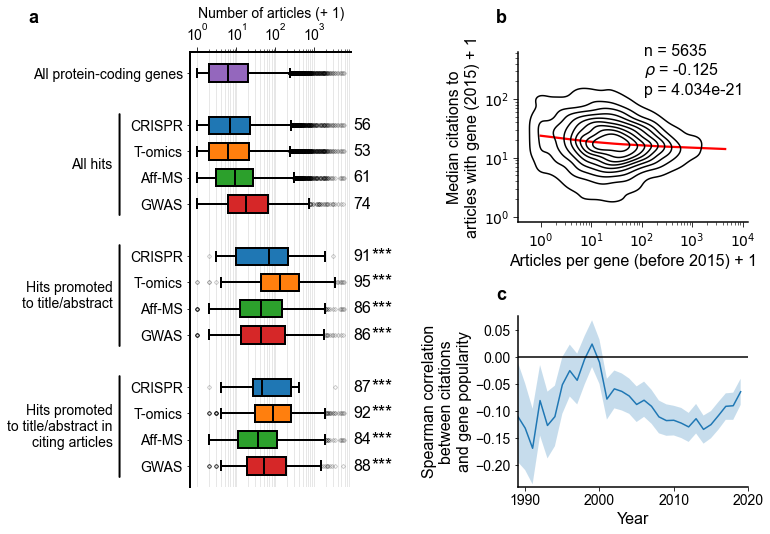

In [24]:
axes = []
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2,
                           hspace=0.55, wspace=0.85, width_ratios=[0.7,1])
fig = plt.figure(figsize=(10,8), constrained_layout=False)


# Fig 1A
ax = fig.add_subplot(gs[0:2, 0])
axes.append(ax)

pad = 0.2

medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')
flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

gene2pubmed_dict = (
        gene2pubmed
    .value_counts('gene_ncbi').to_dict()
    )

ax.boxplot(x=(pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].values,
          vert=False, 
           widths=(pad/1.5),
           positions=[-0.4], 
           whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[4], linewidth=2),
           medianprops=medianprops, 
           whiskerprops=whiskerprops, 
           capprops=capprops, 
           flierprops=flierprops)

labels = ['CRISPR', 'T-omics', 'Aff-MS', 'GWAS']

for hit_type, pad_multiplier, color in zip(['crispr', 'transcriptomics', 'aff_ms', 'gwas'], 
                                    [1,0,-1,-2], sns.color_palette()[0:4]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = hits_df_slice.groupby('set')['gene_ncbi'].apply(set).to_dict()
    
    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    # ECDF
    ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values+1)
    
    data = [(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0) + 1)[0].values,
            #(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits_null')]).fillna(0.0) + 1)[0].values,
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0) + 1)[0].values, 
           (pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0) + 1)[0].values]

    positions = -np.arange(len(data))-1+pad_multiplier*pad
    
    ax.boxplot(x=data,
              vert=False, 
               widths=(pad/1.5),
               positions=positions,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    print(scipy.stats.mannwhitneyu(data[0], data[1]))
    print(scipy.stats.mannwhitneyu(data[0], data[2]))
    max_val = (pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0) + 1)[0].max()
    
    percentiles = ecdf([np.median(dat) for dat in data])
    
    for pos, percentile in zip(positions, percentiles):
        ax.text(s=str(int(percentile*100)), 
                x=max_val*1.7, 
                y=pos, 
                ha='left', va='center', fontsize=16)
    for pos in positions[1:]:
        ax.text(s='***', x=max_val*5, y=pos, ha='left', va='center', fontsize=18)

ax.set_xscale('log')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel('Number of articles (+ 1)', fontsize=14)
yticks = ax.get_yticks()
yticks = np.sort(yticks)[::-1]
ax.set_ylim([np.min(yticks)-pad/1.25, 
             np.max(yticks)+pad/1.25])
ax.set_yticks(ticks=yticks, 
              labels=['All protein-coding genes'] + int(len(yticks)/4)*labels,
              fontsize=14)

ax.xaxis.set_ticks([1,10,100,1000])
a_tick_array = []
for mult in [1, 10, 100, 1000]:
    a_tick_array = a_tick_array + list(mult*np.array([1,2,3,4,5,6,7,8,9]))
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(a_tick_array))

ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', length=5, which='major')
ax.tick_params(axis='x', length=3, which='minor')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]

# y axis labels
xpos_line = 0.01

ax.annotate('', xy=(xpos_line, -0.7), 
            xycoords='data', 
            xytext=(xpos_line, -1.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)
ax.text(s='All hits', 
        y=-1.1, 
        x=xpos_line/1.5, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -1.7), 
            xycoords='data', 
            xytext=(xpos_line, -2.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract', 
        y=-2.1, 
        x=xpos_line/1.5, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -2.7), 
            xycoords='data', 
            xytext=(xpos_line, -3.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\nciting articles', 
        y=-3.1, 
        x=xpos_line/1.5, 
        ha='right', va='center', 
        fontsize=14)

ax.grid(which='both', axis='x', linewidth=1, alpha=0.3)





# Fig 1B
ax = fig.add_subplot(gs[0, 1])
axes.append(ax)

year = 2015
pub_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').count()['pubmed_id']
cite_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').sum()['citation_count']
cite_median = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').median()['citation_count']\

gene2pubmed_dict = gene2pubmed[(~gene2pubmed['pubmed_id'].isin(large_pubs)) & 
            (gene2pubmed['year'] < year)].value_counts('gene_ncbi').to_dict()
def gene2pubmed_gene_count(x):
    ret = gene2pubmed_dict.get(x)
    if ret:
        return ret
    else:
        return 0
        
pub_count_previous = np.array([gene2pubmed_gene_count(x) for x in cite_count.index])

sns.regplot(x=np.log10(pub_count_previous+1), y=np.log10(cite_median+1), lowess=True,
            scatter_kws={"color": "k", 's': 0, 'alpha':0.25, 'linewidth':0}, 
            line_kws={"color": "red"}, ax=ax)
sns.kdeplot(np.log10(pub_count_previous+1), 
            np.log10(cite_median+1), ax=ax, color='k')
#ax.axhline(gene2pubmed_slice[gene2pubmed_slice['year'] == year]['citation_count'].median()+1)
#ax.set_xscale('log')
#ax.set_yscale('log')

ax.tick_params(labelsize=14)
ax.set_ylabel('Median citations to\narticles with gene (' + str(year) + ') + 1', fontsize=16)
ax.set_xlabel('Articles per gene (before ' + str(year) + ') + 1', fontsize=16)
[ax.spines[i].set_linewidth(1.5) for i in ax.spines]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

rho, p = scipy.stats.spearmanr(pub_count_previous, cite_median)
n_genes = len(cite_median)

ax.text(s='n = ' + str(n_genes) + '\n' + r'$\rho$ = {:.3f}'.format(rho) + '\np = ' + '{:.3e}'.format(p), 
        x=0.55, y=0.75, fontsize=16, backgroundcolor='w', bbox={'alpha':0.9, 'color':'w'}, transform=ax.transAxes)
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(tick_array))
ax.yaxis.set_minor_locator(mpl.ticker.FixedLocator(tick_array))
ax.tick_params(axis='both', length=5, which='major')
ax.tick_params(axis='both', length=3, which='minor')
ax.xaxis.set_ticks([0,1,2,3,4], 
                   labels=[r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
ax.yaxis.set_ticks([0,1,2,3,4], 
                   labels=[r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
ax.set_ylim([-0.1,2.8])

# panel c
ax = fig.add_subplot(gs[1, 1])
axes.append(ax)

ax.plot(year_array, corr_array, linewidth=1.5)
ax.fill_between(x=year_array, 
                y1=np.percentile(bootstrap_array, 2.5, axis=1), 
                y2=np.percentile(bootstrap_array, 97.5, axis=1), alpha=0.25)
ax.axhline(0.0, linewidth=1.5, color='k')

ax.tick_params(labelsize=14)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Spearman correlation\nbetween citations\nand gene popularity', fontsize=16, rotation=90)
ax.set_xlim([1989,2020])
ax.set_yticks(np.arange(-0.5,0.5,0.05))
ax.set_ylim([-0.24,0.075])
[ax.spines[i].set_linewidth(1.5) for i in ax.spines]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.text(s='a', x=-0.10, y=0.93, fontsize=18, weight='bold')
fig.text(s='b', x=0.55, y=0.93, fontsize=18, weight='bold')
fig.text(s='c', x=0.55, y=0.45, fontsize=18, weight='bold')

plt.savefig('../img/fig_1_230118.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/fig_1_230118.pdf', bbox_inches='tight')

export.image('general', p='figures/figure_1_.pdf', date=True)
export.raster_image('general', p='figures/figure_1_.png', date=True, dpi=600)

### Variant with percentiles

MannwhitneyuResult(statistic=62853.0, pvalue=1.2640419751699968e-06)
MannwhitneyuResult(statistic=35690.5, pvalue=2.115496210353215e-06)
MannwhitneyuResult(statistic=586352.0, pvalue=3.285001864214169e-112)
MannwhitneyuResult(statistic=1976146.5, pvalue=1.0136443748869454e-265)
MannwhitneyuResult(statistic=1172095.0, pvalue=2.642589532858723e-79)
MannwhitneyuResult(statistic=1287707.0, pvalue=6.183650928057393e-68)
MannwhitneyuResult(statistic=212758.5, pvalue=3.477474547637481e-17)
MannwhitneyuResult(statistic=157535.0, pvalue=6.495936079928239e-23)


meta NOT subset; don't know how to subset; dropped


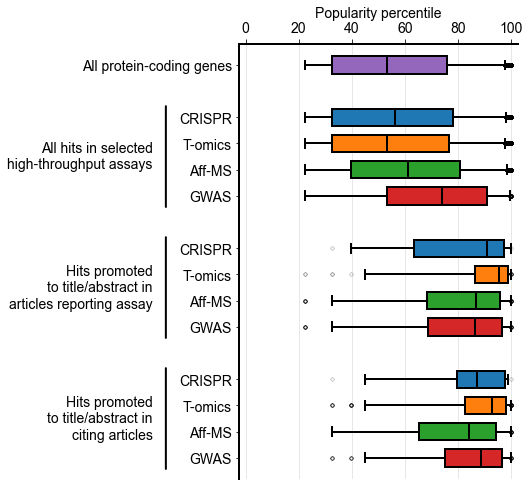

In [25]:
fig = plt.figure(figsize=(5,8))
ax = plt.gca()

pad = 0.2

medianprops = dict(linestyle='solid', linewidth=2, color='k')
whiskerprops = dict(linestyle='solid', linewidth=2, color='k')
capprops = dict(linestyle='solid', linewidth=2, color='k')
flierprops = dict(marker='D', color='k', markersize=3, alpha=0.2)

gene2pubmed_dict = (
        gene2pubmed
    .value_counts('gene_ncbi').to_dict()
    )
# ECDF
ecdf = ECDF((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values)

ax.boxplot(x=ecdf((pd.DataFrame([gene2pubmed_dict.get(x) for x in prot_genes]).fillna(0.0))[0].values),
          vert=False, 
           widths=(pad/1.5),
           positions=[-0.4], 
           whis=[2.5,97.5], patch_artist=True,
           boxprops=dict(facecolor=sns.color_palette()[4], linewidth=2),
           medianprops=medianprops, 
           whiskerprops=whiskerprops, 
           capprops=capprops, 
           flierprops=flierprops)

labels = ['CRISPR', 'T-omics', 'Aff-MS', 'GWAS']

for hit_type, pad_multiplier, color in zip(['crispr', 'transcriptomics', 'aff_ms', 'gwas'], 
                                    [1,0,-1,-2], sns.color_palette()[0:4]):
    hits_df_slice = hits_df[hits_df['type'] == hit_type].copy()
    hits_dict = hits_df_slice.groupby('set')['gene_ncbi'].apply(set).to_dict()
    
    # create gene counts dict with no cutoff year and not including articles in set
    gene2pubmed_dict = (
        gene2pubmed[~gene2pubmed['pubmed_id'].isin(pmid_dict.get(hit_type))]
    .value_counts('gene_ncbi').to_dict()
    )
    
    data = [ecdf((pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('hits')]).fillna(0.0))[0].values),
            #(pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits_null')]).fillna(0.0) + 1)[0].values,
           ecdf((pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('mentioned_hits')]).fillna(0.0))[0].values), 
           ecdf((pd.DataFrame([gene2pubmed_dict.get(x) for x in hits_dict.get('citations_mentioned_hits')]).fillna(0.0))[0].values)]

    positions = -np.arange(len(data))-1+pad_multiplier*pad
    
    ax.boxplot(x=data,
              vert=False, 
               widths=(pad/1.5),
               positions=positions,
               whis=[2.5,97.5], patch_artist=True,
               boxprops=dict(facecolor=color, linewidth=2),
               medianprops=medianprops, 
               whiskerprops=whiskerprops, 
               capprops=capprops, 
               flierprops=flierprops)
    
    print(scipy.stats.mannwhitneyu(data[0], data[1]))
    print(scipy.stats.mannwhitneyu(data[0], data[2]))
    max_val = 1

#ax.set_xscale('log')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xlabel('Popularity percentile', fontsize=14)
yticks = ax.get_yticks()
yticks = np.sort(yticks)[::-1]
ax.set_ylim([np.min(yticks)-pad/1.25, 
             np.max(yticks)+pad/1.25])
ax.set_yticks(ticks=yticks, 
              labels=['All protein-coding genes'] + int(len(yticks)/4)*labels,
              fontsize=14)
ax.set_xticks(ticks=np.arange(0,1.1, 0.2), labels=np.arange(0,110, 20))
ax.tick_params(axis='both', labelsize=14)
ax.tick_params(axis='x', length=5, which='major')
ax.tick_params(axis='x', length=3, which='minor')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
[ax.spines[i].set_linewidth(2) for i in ax.spines]
ax.set_xlim([-0.025, 1.025])
# y axis labels
xpos_line = -0.3

ax.annotate('', xy=(xpos_line, -0.7), 
            xycoords='data', 
            xytext=(xpos_line, -1.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)
ax.text(s='All hits in selected\nhigh-throughput assays', 
        y=-1.1, 
        x=xpos_line-0.05,
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -1.7), 
            xycoords='data', 
            xytext=(xpos_line, -2.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\narticles reporting assay', 
        y=-2.1, 
        x=xpos_line-0.05, 
        ha='right', va='center', 
        fontsize=14)

ax.annotate('', xy=(xpos_line, -2.7), 
            xycoords='data', 
            xytext=(xpos_line, -3.5), 
            arrowprops=dict(arrowstyle="-", color='k', linewidth=2, capstyle='round'), 
            annotation_clip=False)

ax.text(s='Hits promoted\nto title/abstract in\nciting articles', 
        y=-3.1, 
        x=xpos_line-0.05, 
        ha='right', va='center', 
        fontsize=14)

ax.grid(which='both', axis='x', linewidth=1, alpha=0.3)

plt.savefig('../img/filter_figure_percentile_variant_230118.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/filter_figure_percentile_variant_230118.pdf', bbox_inches='tight')

#export.image('general', p='figures/filter_figure.pdf', date=True)
#export.raster_image('general', p='figures/filter_figure.png', date=True, dpi=600)